In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity

In [60]:
path = Path("/kaggle/input/utkface-new/UTKFace")
filenames = [file.name for file in path.glob('*.jpg')]

In [61]:
print(len(filenames))
print(filenames[:3])

23708
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg']


In [62]:
# Shuffle the filenames
np.random.seed(10)
np.random.shuffle(filenames)

# Extract age and gender labels from filenames
image_paths = [str(file) for file in filenames]  # Convert Path objects to strings
age_labels = [file.split('_')[0] for file in filenames]
gender_labels = [file.split('_')[1] for file in filenames]

In [63]:
image_paths[:3]

['39_0_1_20170113151528768.jpg.chip.jpg',
 '51_0_0_20170111203742983.jpg.chip.jpg',
 '34_0_1_20170116002253177.jpg.chip.jpg']

In [64]:
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
})

In [65]:
df.head()

,image,age,gender
0,39_0_1_20170113151528768.jpg.chip.jpg,39,0
1,51_0_0_20170111203742983.jpg.chip.jpg,51,0
2,34_0_1_20170116002253177.jpg.chip.jpg,34,0
3,15_1_2_20170104012024121.jpg.chip.jpg,15,1
4,22_1_0_20170116214345265.jpg.chip.jpg,22,1


In [66]:
df.dtypes

image     object
age       object
gender    object
dtype: object

In [67]:
df = df.astype({'age':'float32', 'gender': 'int32'})

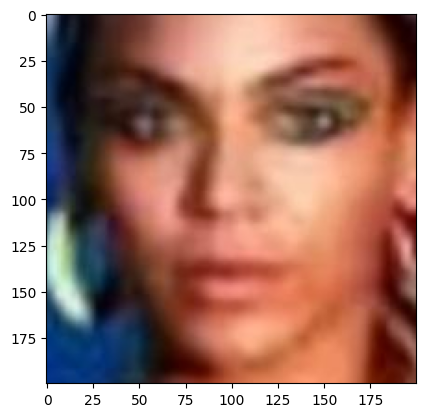

In [111]:
img = Image.open("/kaggle/input/utkface-new/UTKFace/" + df['image'][10])
plt.imshow(img)
plt.show()

/tmp/ipykernel_34/3234920688.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='age', ylabel='Density'>

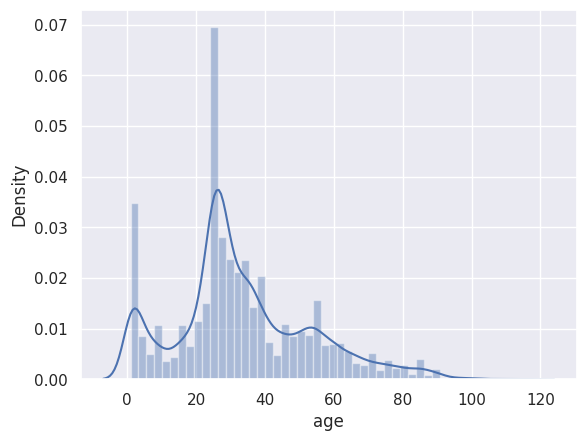

In [130]:
sns.distplot(df['age'])

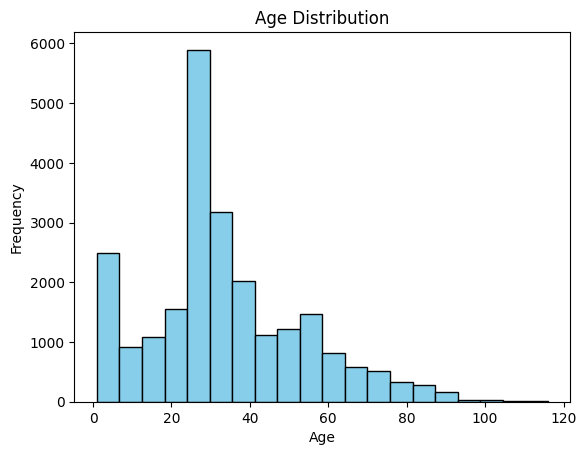

In [69]:
# Histogram of age
plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

In [110]:
import plotly.express as px
gender_mapping = ["Male", "Female"]
male_count = 0
ages = []
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
female_count = len(image_paths) - male_count
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    title = "Gender Distribution Donut Chart",
    height = 500
)
pie_chart.show()

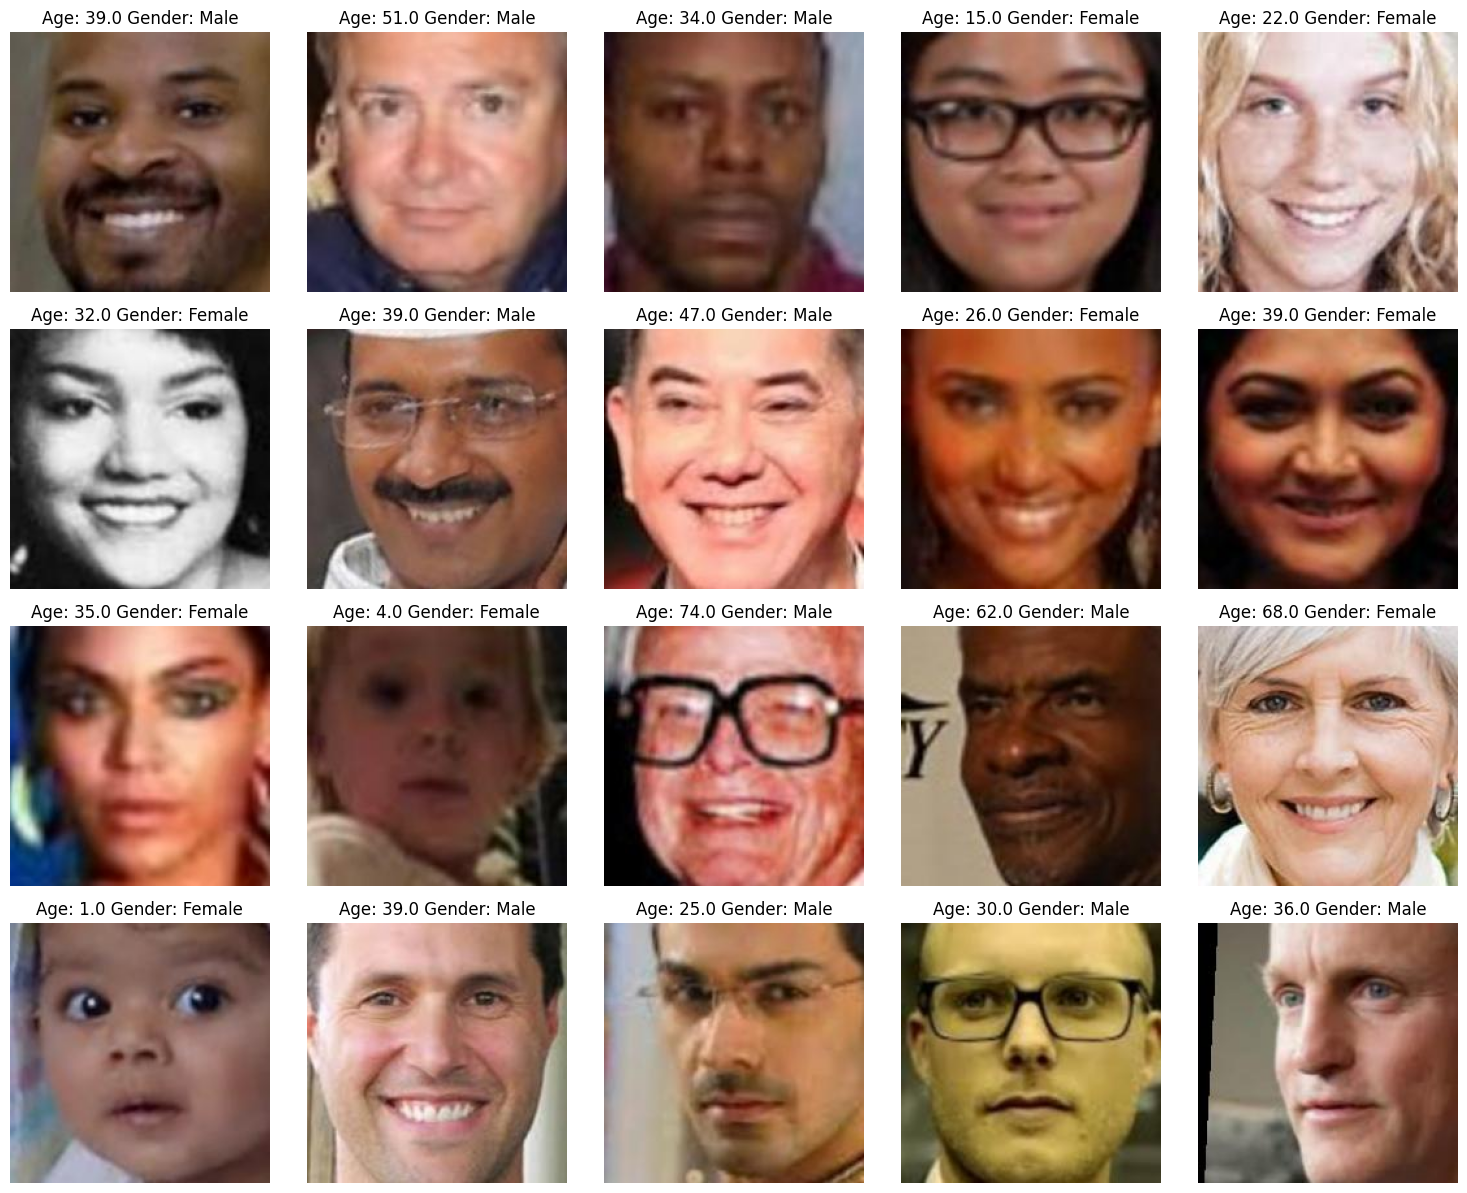

In [71]:
from keras.preprocessing.image import load_img

gender_dict = {0: 'Male', 1: 'Female'}

files = df.iloc[0:20]
plt.figure(figsize=(15, 15))
for index, (file, age, gender) in files.iterrows():
    plt.subplot(5, 5, index + 1)
    img = load_img("/kaggle/input/utkface-new/UTKFace/" + file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [72]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.85, random_state=42)

train.head()

,image,age,gender
6045,115_1_0_20170120134725991.jpg.chip.jpg,115.0,1
7503,21_1_0_20170117193737828.jpg.chip.jpg,21.0,1
12843,49_0_0_20170117135838690.jpg.chip.jpg,49.0,0
14525,47_0_0_20170105173116787.jpg.chip.jpg,47.0,0
9728,32_1_1_20170113000438328.jpg.chip.jpg,32.0,1


In [73]:
from keras.preprocessing.image import load_img

x_train = []
for file in train.image:
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/opt/conda/lib/python3.10/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
/tmp/ipykernel_34/3798594471.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [74]:
x_train.shape

(16595, 128, 128, 1)

In [75]:
x_train = x_train/255

In [76]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [77]:
input_size = (128, 128, 1)

In [78]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model

inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [79]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [80]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 126, 126, 64)         640       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 126, 126, 64)         256       ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 42, 42, 64)           0         ['batch_normalization_2[

In [85]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 32, epochs=50, validation_split= 0.2)

Epoch 1/50
415/415 [==============================] - 8s 20ms/step - loss: 3.2419 - gender_output_loss: 0.0527 - age_output_loss: 3.1892 - gender_output_accuracy: 0.9766 - age_output_accuracy: 0.0188 - val_loss: 7.8051 - val_gender_output_loss: 0.6414 - val_age_output_loss: 7.1637 - val_gender_output_accuracy: 0.8891 - val_age_output_accuracy: 0.0377
Epoch 2/50
415/415 [==============================] - 7s 18ms/step - loss: 3.2837 - gender_output_loss: 0.0488 - age_output_loss: 3.2350 - gender_output_accuracy: 0.9770 - age_output_accuracy: 0.0192 - val_loss: 7.7036 - val_gender_output_loss: 0.9699 - val_age_output_loss: 6.7338 - val_gender_output_accuracy: 0.8816 - val_age_output_accuracy: 0.0395
Epoch 3/50
415/415 [==============================] - 8s 18ms/step - loss: 3.2228 - gender_output_loss: 0.0705 - age_output_loss: 3.1523 - gender_output_accuracy: 0.9747 - age_output_accuracy: 0.0174 - val_loss: 7.2559 - val_gender_output_loss: 0.7062 - val_age_output_loss: 6.5497 - val_gender

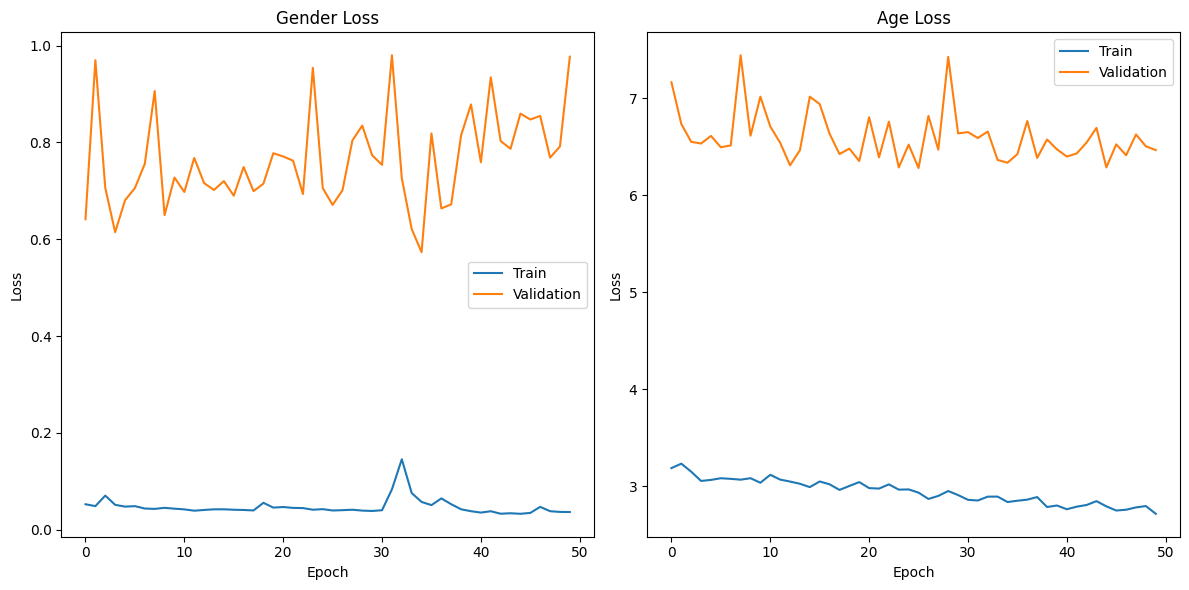

In [86]:
# Plotting gender and age losses together
plt.figure(figsize=(12, 6))

# Gender loss
plt.subplot(1, 2, 1)
plt.plot(model_history.history['gender_output_loss'], label='Train')
plt.plot(model_history.history['val_gender_output_loss'], label='Validation')
plt.title('Gender Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Age loss
plt.subplot(1, 2, 2)
plt.plot(model_history.history['age_output_loss'], label='Train')
plt.plot(model_history.history['val_age_output_loss'], label='Validation')
plt.title('Age Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Original: Gender =  Female  Age =  30.0
1/1 [==============================] - 0s 18ms/step
Prediction: Gender =  Female  Age =  31


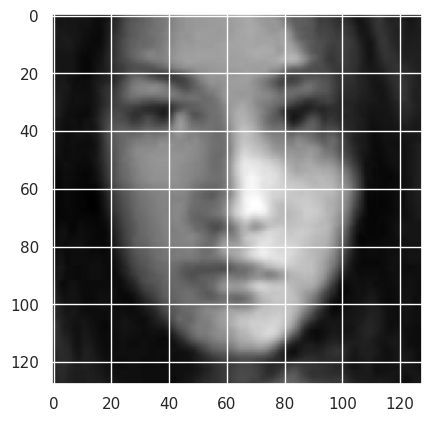

Original: Gender =  Female  Age =  27.0
1/1 [==============================] - 0s 18ms/step
Prediction: Gender =  Female  Age =  26


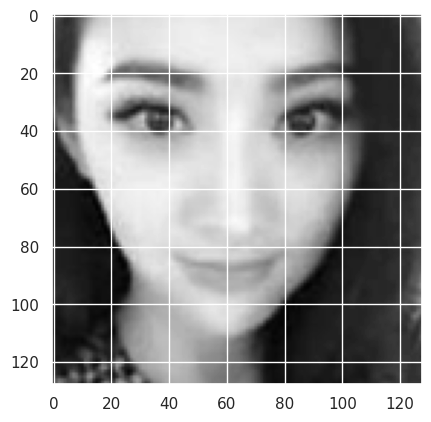

Original: Gender =  Female  Age =  22.0
1/1 [==============================] - 0s 17ms/step
Prediction: Gender =  Female  Age =  22


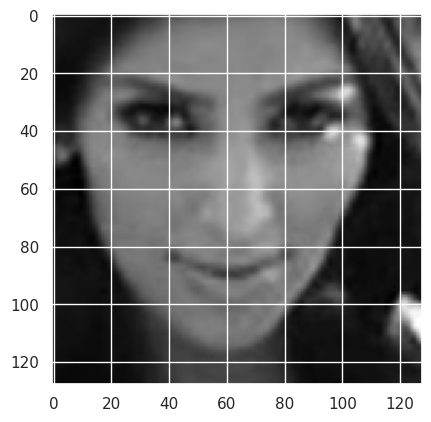

In [139]:
# Define a function for predicting and visualizing multiple test images
def predict_and_visualize(index_list, x_test, y_gender_true, y_age_true, model, gender_dict):
    for index in index_list:
        print("Original: Gender = ", gender_dict[y_gender_true[index]], " Age = ", y_age_true[index])

        # Predict gender and age
        pred = model.predict(x_test[index].reshape(1, 128, 128, 1))
        pred_gender = gender_dict[round(pred[0][0][0])]
        pred_age = round(pred[1][0][0])

        print("Prediction: Gender = ", pred_gender, " Age = ", pred_age)

        # Display the image
        plt.imshow(x_test[index].reshape(128, 128), cmap='gray')
        plt.show()

# Example usage:
index_list = [1200,4666,15000]  # List of indices of test images to predict and visualize
predict_and_visualize(index_list, x_train, y_gender, y_age, model, gender_dict)

In [91]:
print(model_history.history.keys())

dict_keys(['loss', 'gender_output_loss', 'age_output_loss', 'gender_output_accuracy', 'age_output_accuracy', 'val_loss', 'val_gender_output_loss', 'val_age_output_loss', 'val_gender_output_accuracy', 'val_age_output_accuracy'])


In [101]:
print(model_history.history['gender_output_accuracy'][-1])

0.9795119166374207


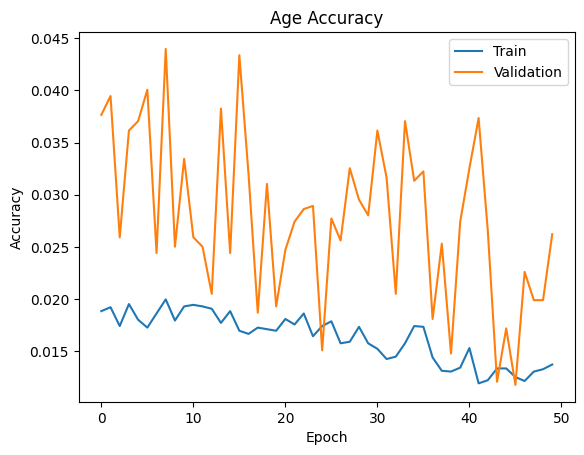

In [109]:
plt.plot(model_history.history['age_output_accuracy'], label='Train')
plt.plot(model_history.history['val_age_output_accuracy'], label='Validation')
plt.title('Age Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()